In [1]:
import os

import numpy as np 
import pandas as pd 
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from random import sample
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Inspect the base directory
base_dir = '/kaggle/input'
for root, dirs, files in os.walk(base_dir):
    print(root)
    for file in files:
        if '.jpg' not in file:
            print(os.path.join(root,file))            

/kaggle/input
/kaggle/input/ukraine-ml-bootcamp-2023
/kaggle/input/ukraine-ml-bootcamp-2023/sample_submission.csv
/kaggle/input/ukraine-ml-bootcamp-2023/train.csv
/kaggle/input/ukraine-ml-bootcamp-2023/images
/kaggle/input/ukraine-ml-bootcamp-2023/images/train_images
/kaggle/input/ukraine-ml-bootcamp-2023/images/test_images


In [3]:
# Set paths to the input data
train_img_dir = '/kaggle/input/ukraine-ml-bootcamp-2023/images/train_images/'
test_img_dir = '/kaggle/input/ukraine-ml-bootcamp-2023/images/test_images/'
train_data = '/kaggle/input/ukraine-ml-bootcamp-2023/train.csv'
test_data = '/kaggle/input/ukraine-ml-bootcamp-2023/sample_submission.csv'

In [4]:
# Set the dataframe
df = pd.read_csv(train_data)

# Inspect the dataframe
df.head()

,image_id,class_6
0,1daf45401342ac321c0aa5668f51d004.jpg,5
1,7e15c14f0b25766d0b7378f1d5328e99.jpg,4
2,1dc97053cf67cb8e51c983abb0021083.jpg,4
3,0ceaf686d3b9c1db537fed12b568670d.jpg,1
4,73adbf71f0adcf89c94339f6a6a92b61.jpg,0


In [5]:
# Check the dataframe for missing values
df.isna().sum()

image_id    0
class_6     0
dtype: int64

In [6]:
# Check if all the file names are unique
len(df['image_id']) == len(df['image_id'].value_counts())

True

Number of classes: 6
Image classes: [0, 1, 2, 3, 4, 5]


<Axes: title={'center': 'Number of Image Examples per Class'}, xlabel='Class', ylabel='Number of examples'>

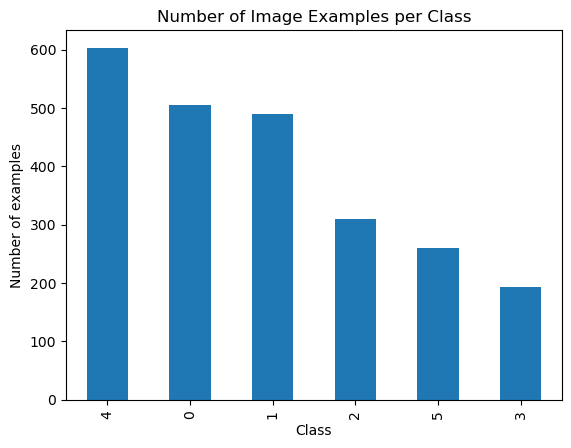

In [7]:
# Check image classes and image distribution by classes
num_classes = len(df["class_6"].unique())
print(f'Number of classes: {num_classes}')
print(f'Image classes: {sorted(df["class_6"].unique())}')
df["class_6"].value_counts().plot(kind='bar',
                                  xlabel='Class',
                                  ylabel='Number of examples',
                                  title='Number of Image Examples per Class')

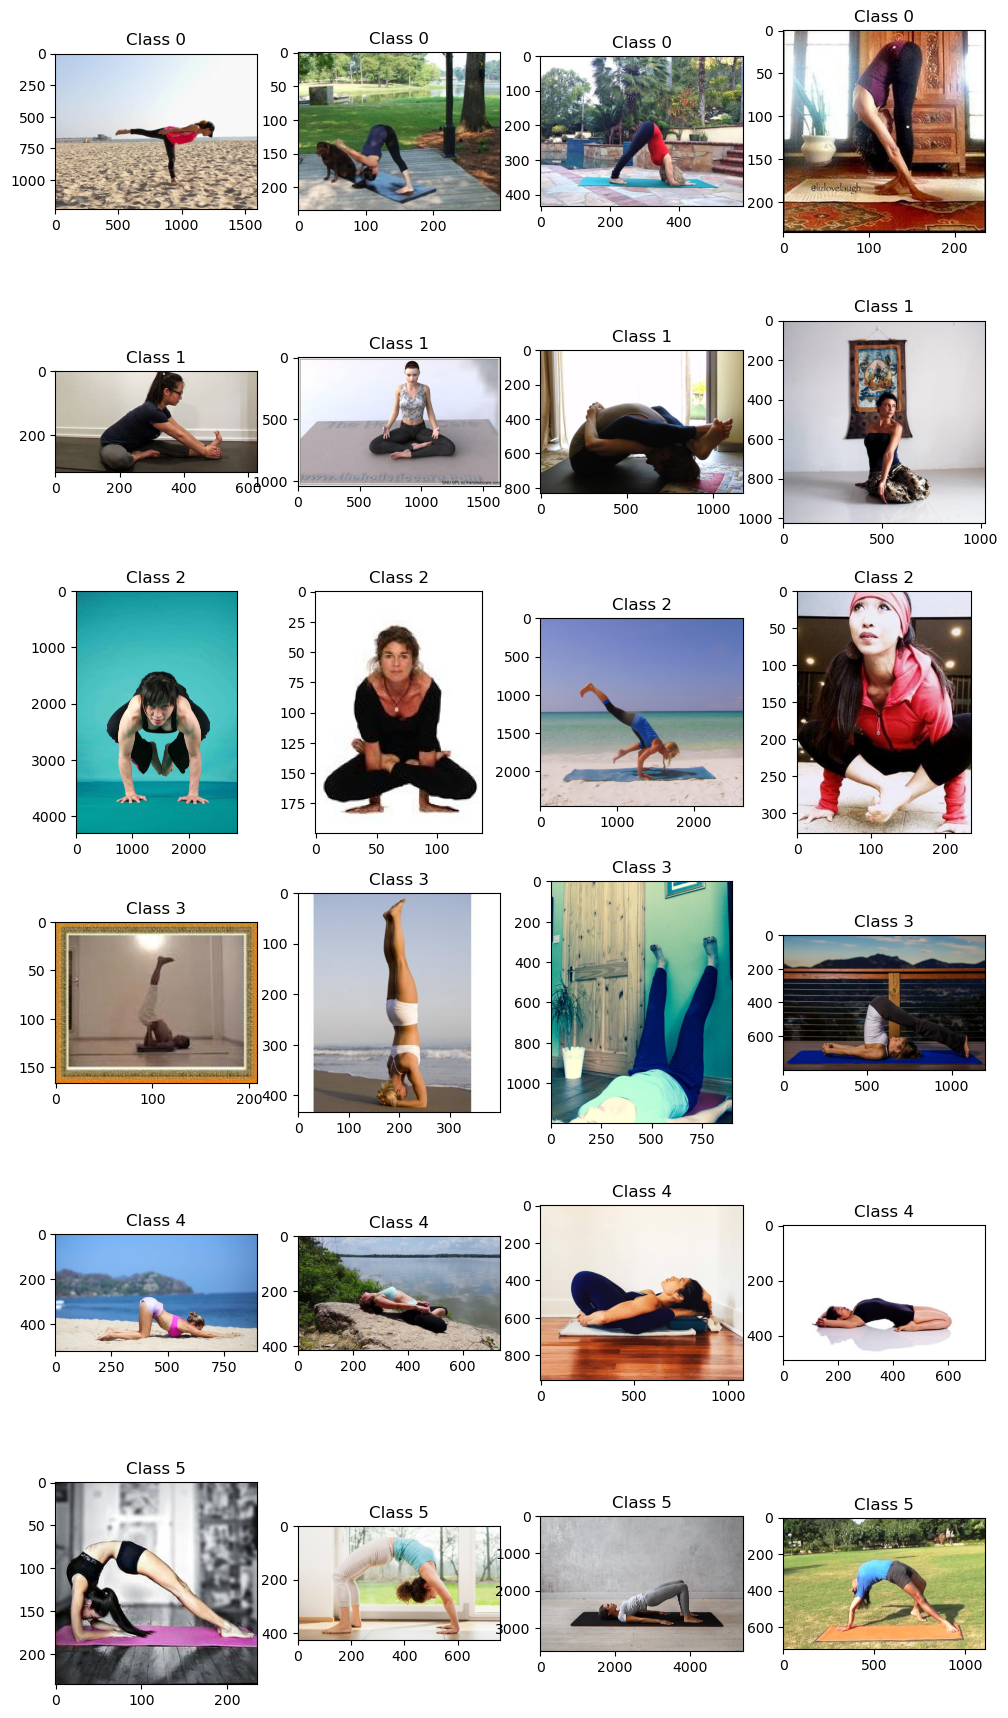

In [8]:
# Group images by classes
class_groups = df.groupby('class_6').groups

# Plot images by classes
plt.figure(figsize=(12,22))
i = 1
for group in class_groups:
    sub_group = sample(list(class_groups[group]), 4)
    images = [os.path.join(train_img_dir, df['image_id'][ind]) for ind in sub_group]
    for img in images:
        plt.subplot(num_classes, 4, i)
        plt.title(f'Class {group}')
        with Image.open(img) as im:
            plt.imshow(im)
        i += 1

In [9]:
# Set parameters
learning_rate = 0.001 
train_size = 0.9
epochs = 50
batch_size = 32
target_size = (299, 299)

In [10]:
# Split the dataframe to a train dataframe and a validation dataframe
# using stratification since the dataset is imbalanced as shown above
train_df, val_df = train_test_split(df, train_size=train_size,
                                    stratify=df['class_6'])

In [11]:
# Cast classes to the string type as ImageDataGenerator demands
train_df['class_6'] = train_df['class_6'].astype(str)
val_df['class_6'] = val_df['class_6'].astype(str)

# Use ImageDataGenrator for image preprocessing
# considering the following:
# - Apply image augmentation to training images
# - Use a preprocessing function as the base model demands
train_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=5,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function = preprocess_input)

val_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input)

# Get a train generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_img_dir,
    x_col='image_id',
    y_col='class_6',
    color_mode='rgb',
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True)

# Get a validation generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_img_dir,
    x_col='image_id',
    y_col='class_6',
    color_mode='rgb',
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False)  
    

Found 2124 validated image filenames belonging to 6 classes.
Found 236 validated image filenames belonging to 6 classes.


In [12]:
# Build a model
base_model = Xception(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes)(x)
model = Model(base_model.input, x)

83683744/83683744 [==============================] - 3s 0us/step


In [13]:
# Set callbacks
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0.001,
                           patience=10,
                           verbose=1,
                           mode='max',
                           restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", 
                              patience=3, 
                              verbose=1, 
                              factor=0.5,
                              mode="auto",
                              cooldown=0)
model_checkpoint = ModelCheckpoint('best_model_xception.h5',
                                   monitor='val_accuracy',
                                   mode='max',
                                   verbose=1,
                                   save_best_only=True)

In [14]:
# Set optimizer, loss and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
f1_score = tfa.metrics.F1Score(num_classes=num_classes, average="micro")

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[f1_score,'accuracy'])

In [15]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr, model_checkpoint])

Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 1.7617 - f1_score: 0.2307 - accuracy: 0.2307
Epoch 1: val_accuracy improved from -inf to 0.25424, saving model to best_model_xception.h5
67/67 [==============================] - 122s 1s/step - loss: 1.7617 - f1_score: 0.2307 - accuracy: 0.2307 - val_loss: 1.7020 - val_f1_score: 0.2542 - val_accuracy: 0.2542 - lr: 0.0010
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 1.4872 - f1_score: 0.4562 - accuracy: 0.4562
Epoch 2: val_accuracy did not improve from 0.25424
67/67 [==============================] - 67s 990ms/step - loss: 1.4872 - f1_score: 0.4562 - accuracy: 0.4562 - val_loss: 16.5906 - val_f1_score: 0.1525 - val_accuracy: 0.1525 - lr: 0.0010
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 1.1143 - f1_score: 0.5942 - accuracy: 0.5942
Epoch 3: val_accuracy improved from 0.25424 to 0.36017, saving model to best_model_xception.h5
67/67 [==============================] - 67s 1s/st

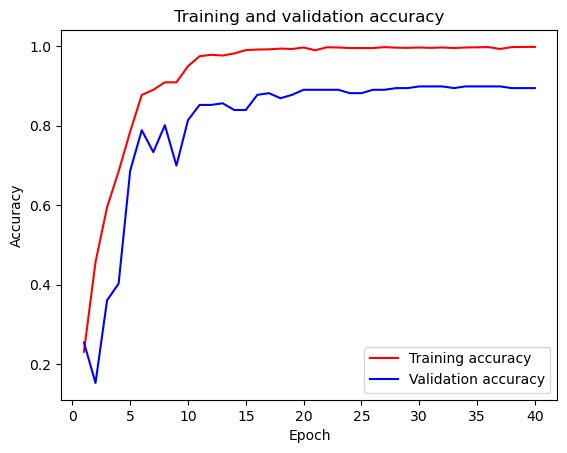

<Figure size 640x480 with 0 Axes>

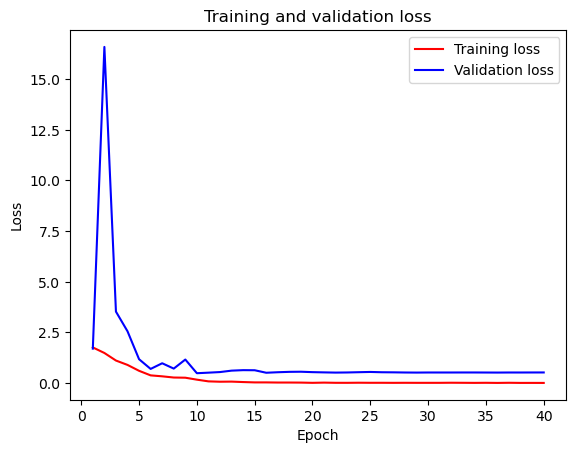

<Figure size 640x480 with 0 Axes>

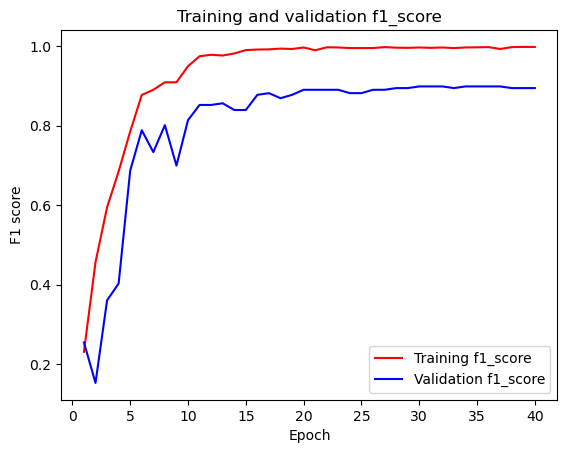

<Figure size 640x480 with 0 Axes>

In [23]:
# Plot metrics
def plot_metrics(name, validation=True):
    epochs = range(1, len(history.history[f"{name}"])+1)
    plt.plot(epochs, history.history[f"{name}"], 'r', label=f"Training {name}")
    if validation:
        plt.plot(epochs, history.history[f"val_{name}"], 'b', label=f"Validation {name}")
        plt.title(f"Training and validation {name}")
    else:
        plt.title(f"Training {name}")
    plt.xlabel('Epoch')
    plt.ylabel(name.capitalize().replace('_', ' '))
    plt.legend(loc=0)
    plt.figure()

    plt.show()
    
plot_metrics("accuracy")
plot_metrics("loss")
plot_metrics("f1_score")

In [24]:
# Show the best epoch
val_f1_score = history.history['val_f1_score']
max_val_f1_score = max(val_f1_score)
epoch = val_f1_score.index(max_val_f1_score)+1
print(f'The best epoch is {epoch} with f1 score of {max_val_f1_score}')

The best epoch is 30 with f1 score of 0.8983050584793091


In [36]:
# Set a test dataframe
test_df = pd.read_csv(test_data)

# Get a test generator
test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_img_dir,
    x_col="image_id",
    y_col=None,
    color_mode='rgb',
    batch_size=1,
    shuffle=False,
    class_mode=None,
    target_size=target_size)

# Get the best model
best_model = tf.keras.models.load_model('/kaggle/working/best_model_xception.h5')
# Get the model predictions on test data
predictions = best_model.predict(test_generator)
# Convert predictions to probabilities using softmax function
probabilities = tf.nn.softmax(predictions).numpy()
# Record probabilities based classes to the test dataframe
test_df['class_6'] = np.argmax(probabilities, axis=-1)
# Save the test dataframe to a csv file for submission
test_df.to_csv('/kaggle/working/submission_xcept.csv', index=False)

Found 756 validated image filenames.
756/756 [==============================] - 12s 14ms/step
